In [35]:
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno
import pandas_bokeh
from datetime import datetime


# System libraries to import the data
import os.path 
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Chargement de la bibliothéque Bootstrap et du module HTML
from IPython.core.display import display, Markdown, Latex, HTML
HTML(open("./styles/theme.min.css", "r").read())

# afficher jusqu'a 500 lignes
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from pandas_profiling import ProfileReport

from collections import Counter
from wordcloud import WordCloud

# Create Bokeh-Table with DataFrame:
from bokeh.models.widgets import DataTable, TableColumn
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_file, save


In [17]:
HTML(open("styles/theme.min.css", "r").read())

In [18]:
#Style pour les titres de tableau
styles = [dict(selector="caption", 
    props=[("text-align", "center"),
    ("font-size", "120%"),
    ("font-weight", "bold"),
    ("color", 'black')])] 

In [19]:
pandas_bokeh.output_notebook()

Loading BokehJS ...

<div class="jumbotron">
<h1>Santé Publique France</h1>
<h2>Analyse des données Open Food Facts</h2>
<p><strong>Projet n°3</strong></p>
<p><a href="https://openclassrooms.com/fr/paths/188/projects/718/assignment" target="blank" class="btn btn-primary btn-lg">Plus d'infos</a></p><img src="https://consent.trustarc.com/get?name=oc_logo.png" width="200px">
</div>

<hr /><h1 style="text-align: center;"><span style="color: #666699;">💾 <em><strong>Importation et apercu du jeu de données</strong></em></span></h1>

In [20]:
# Telechargement et extraction du jeu de donnés
data_local_path = 'data/'
csv_filename = 'fr.openfoodfacts.org.products.csv'
csv_local_path = data_local_path+csv_filename

# Seulement si les fichiers ne sont pas encore importés
if not os.path.isfile(csv_local_path):
    zip_filename = csv_filename+'.zip'
    zip_url = 'https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/'+zip_filename
    zip_local_path = data_local_path+zip_filename

    with urlopen(zip_url) as zip_response:
        with ZipFile(BytesIO(zip_response.read())) as zip_file:
            # extraction des fichiers dans data_local_path
            zip_file.extractall(data_local_path)

In [21]:
#Modificcation du CSV car des cellules contiennent des sauts de ligne "\n"
clean_filename = 'fr.openfoodfacts.org.products-clean.csv'
clean_local_path = data_local_path+clean_filename

if not os.path.isfile(clean_local_path):
    # Seulement si les fichiers ne sont pas encore importés
    with open(csv_local_path, 'r', encoding="utf8") as csv_file, open(clean_local_path, 'w', encoding="utf8") as clean_file:
        dataw = csv_file.read()
        clean_file.write(dataw.replace('\n\t', '\t'))

In [22]:
raw_df = pd.read_csv(clean_local_path, encoding="utf-8",sep="\t", low_memory=False)
raw_df.head(2)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.000,14.000,NaN,NaN


<h1 style="text-align: center;"><span style="color: #666699;">🔎<em><strong> Description et exploration des données</strong></em></span></h1>

<hr/><h2 style="text-align: center;"><span style="color: #666699;"><em><strong>Infos générales</strong></em></span></h2>

In [23]:
raw_df.info()
raw_df.describe(include = 'all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320749 entries, 0 to 320748
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(108), int64(2), object(52)
memory usage: 396.4+ MB


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
count,320749,320749,320747,320749.000,320748,320749.000,320749,302987,52773,104800,...,49.000,3046.000,165.000,948.000,0.000,268.000,221233.000,221233.000,0.000,0.000
unique,320749,320749,3533,NaN,189555,NaN,180491,221343,38562,13816,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,3095757139018,http://world-fr.openfoodfacts.org/produit/3256...,usda-ndb-import,NaN,2017-03-09T10:37:09Z,NaN,2015-08-09T17:35:42Z,Ice Cream,Pâtes alimentaires au blé dur de qualité supér...,500 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,169868,NaN,20,NaN,33,410,201,4669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,1470622403.138,NaN,1478938315.566,NaN,NaN,NaN,NaN,...,6.426,31.377,15.412,49.548,NaN,341.701,9.165,9.057,NaN,NaN
std,NaN,NaN,NaN,33069995.548,NaN,20840300.235,NaN,NaN,NaN,NaN,...,2.048,31.948,3.753,18.758,NaN,425.211,9.056,9.183,NaN,NaN
min,NaN,NaN,NaN,0.000,NaN,1332368132.000,NaN,NaN,NaN,NaN,...,0.000,0.000,8.000,6.000,NaN,0.000,-15.000,-15.000,NaN,NaN
25%,NaN,NaN,NaN,1462983725.000,NaN,1479388918.000,NaN,NaN,NaN,NaN,...,6.300,0.000,12.000,32.000,NaN,98.750,1.000,1.000,NaN,NaN
50%,NaN,NaN,NaN,1489058039.000,NaN,1489062401.000,NaN,NaN,NaN,NaN,...,7.200,22.100,15.000,50.000,NaN,195.750,10.000,9.000,NaN,NaN
75%,NaN,NaN,NaN,1489078649.000,NaN,1489092826.000,NaN,NaN,NaN,NaN,...,7.400,50.950,15.000,64.250,NaN,383.200,16.000,16.000,NaN,NaN


<hr/><h2 style="text-align: center;"><span style="color: #666699;"><em><strong>Apércu des Valeurs manquantes</strong></em></span></h2>

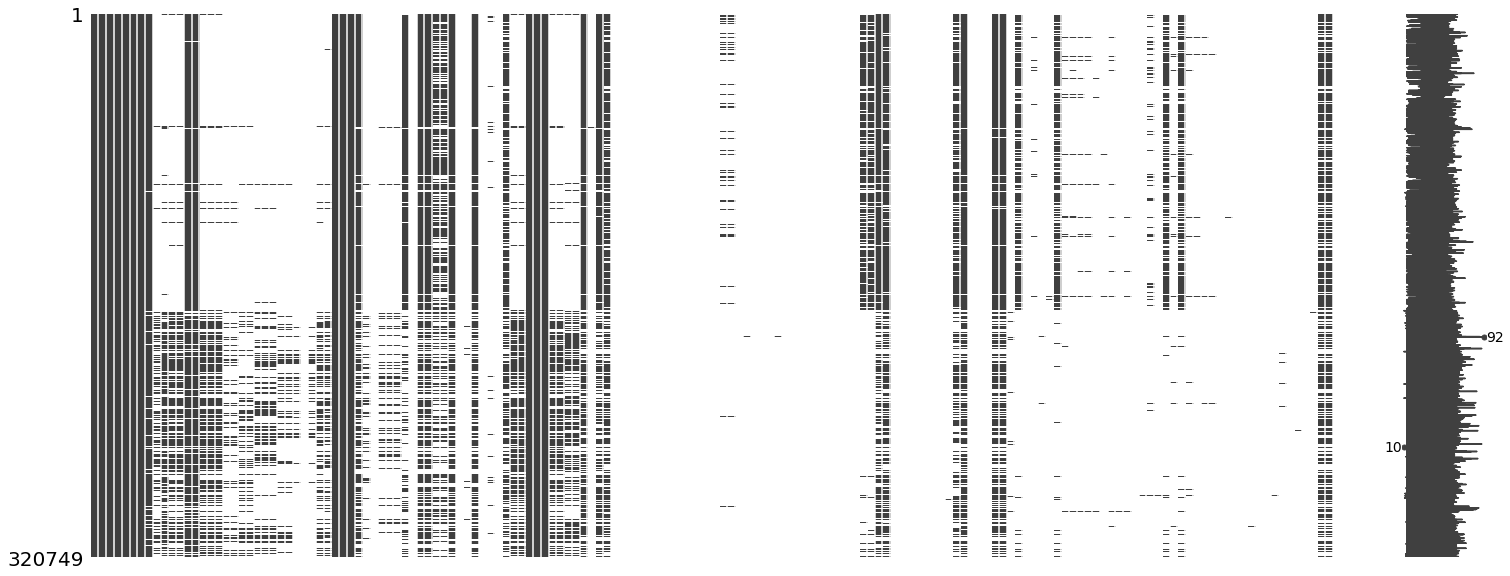

In [24]:
fig = msno.matrix(raw_df)
fig_copy = fig.get_figure()
fig_copy.savefig('misplot.png', bbox_inches = 'tight')

Text(0.5, 1.0, 'Missing values by feature')

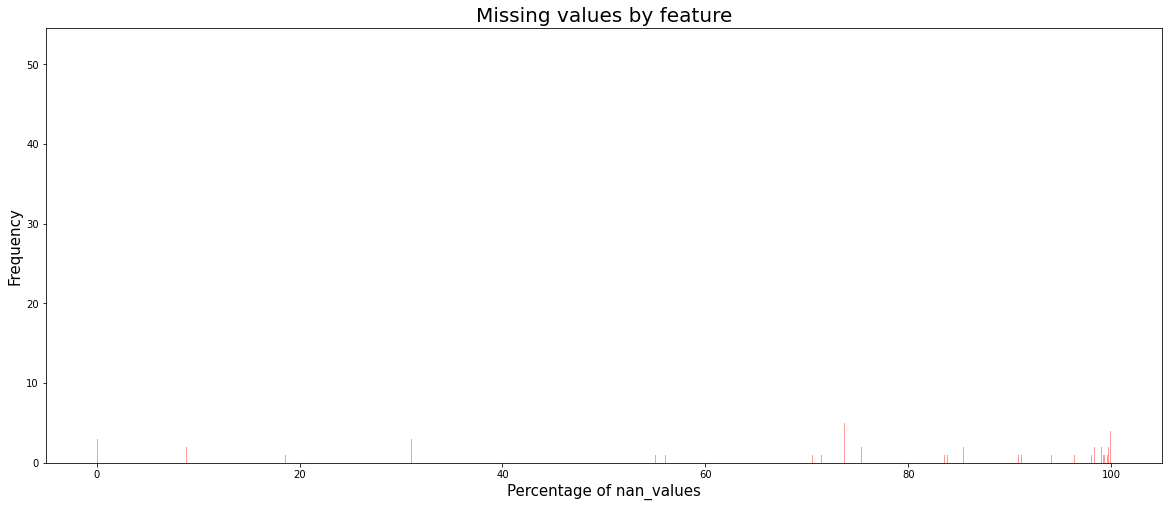

In [25]:
nan_values = raw_df.isnull().sum()
nan_values = nan_values / raw_df.shape[0] *100

plt.figure(figsize=(20,8))
sns.distplot(nan_values, kde=False, bins=np.int(raw_df.shape[0]/100), color = "Red")
plt.xlabel("Percentage of nan_values", size = 15)
plt.ylabel("Frequency", size = 15)
plt.title("Missing values by feature", size = 20)

In [26]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes

        return mz_table
print("def missing_zero_values_table(df)")

def missing_zero_values_table(df)


In [27]:
miss = missing_zero_values_table(raw_df)
type(miss.head(10))

pandas.core.frame.DataFrame

<hr/>
<h1 style="text-align: center;"><span style="color: #666699;">🚿<em><strong>Néttoyage des données</strong></em></span></h1>

<h2 style="text-align: center;"><span style="color: #666699;">🚿<em><strong> Step 1 - Suppression des eventuelles lignes vides</strong></em></span></h2>

#### On retire les colonnes complétements vides

In [29]:
def empty_col(df):
    dfc = df.copy()
    dfc.dropna(how='all', axis=0, inplace=True)
    return dfc

clean_step_1 = empty_col(raw_df)

print("Original number of rows: " + str(raw_df.shape[0]))
print("Number of empty rows: " + str(raw_df.shape[0] - clean_step_1.shape[0]))
print("Number of acutal rows: " + str(clean_step_1.shape[0]))

Original number of rows: 320749
Number of empty rows: 0
Number of acutal rows: 320749


<h2 style="text-align: center;"><span style="color: #666699;">🚿<em><strong>Step 2 - Suppression des eventuels doublons</strong></em></span></h2>

#### On retire les doublons

In [30]:
def duplicate_row(df):
    dfc = df.copy()
    dfc.drop_duplicates()
    return dfc

clean_step_2 = duplicate_row(clean_step_1)

print("Number of rows: " + str(len(clean_step_1)))
print("Number of duplicated rows: " + str(clean_step_1.duplicated().sum()))
print("Number of acutal rows: " + str(len(clean_step_1) - clean_step_2.duplicated().sum()))

Number of rows: 320749
Number of duplicated rows: 0
Number of acutal rows: 320749


<h2 style="text-align: center;"><span style="color: #666699;">🚿<em><strong>Step 3 - Suppression des colonnes ayant moins de n% de remplissage</strong></em></span></h2>

#### Après avoir regarder le tableau des valeurs manquantes on decide du % de remplisssage minimun

In [38]:
missing_zero_values_table(clean_step_2)

pandas.core.frame.DataFrame

In [49]:
mzvt = round(missing_zero_values_table(clean_step_2),2)
mzvt['index'] = mzvt.index
mzvt = mzvt[['index', '% Total Zero Missing Values', '% of Total Values', 'Missing Values',
       'Total Zero Missing Values', 'Zero Values']]
data_table = DataTable(
    columns=[TableColumn(field=Ci, title=Ci) for Ci in mzvt.columns],
    source=ColumnDataSource(mzvt),
    sizing_mode='stretch_width',
    #index_header='mois',
    reorderable = True
    
)
output_file(filename="C:/wamp64/www/p3/sites/default/files/mzvt.html", title="Static HTML file")

show(data_table)


#### Suppression des colonnes ayant moins de 90% de remplissage

In [17]:
def split_col_by_nan(df, n):
    dfc = df.copy()
    miss = missing_zero_values_table(dfc)
    return dfc[miss[miss['% Total Zero Missing Values']<n].index]


clean_step_3 = split_col_by_nan(clean_step_2, 90)

print("Original number of features: " + str(clean_step_2.shape[1]))
print("Number of empty features: " + str(clean_step_2.shape[1] - clean_step_3.shape[1]))
print("Number of acutal features: " + str(clean_step_3.shape[1]))

Original number of features: 162
Number of empty features: 103
Number of acutal features: 59


<hr/><h2 style="text-align: center;"><span style="color: #666699;">🚿<em><strong>Step 4 - Selection des variables à retenir pour l'analyse</strong></em></span></h2>

#### Colonnes actuelles

In [18]:
#liste des colonnes
column_names = clean_step_3.columns.values
column_names

array(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity', 'packaging', 'packaging_tags',
       'brands', 'brands_tags', 'categories', 'categories_tags',
       'categories_fr', 'manufacturing_places',
       'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr',
       'purchase_places', 'stores', 'countries', 'countries_tags',
       'countries_fr', 'ingredients_text', 'serving_size', 'additives_n',
       'additives', 'additives_tags', 'additives_fr',
       'nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2', 'states',
       'states_tags', 'states_fr', 'main_category', 'main_category_fr',
       'image_url', 'image_small_url', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'cholesterol_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100

#### Colonnes retenues pour l'analyse

In [19]:
# Les colonnes que l'on va garder
new_columns = [
    # informations sur le produit
    'code', 'product_name', 'created_datetime', 
    'categories_fr', 'pnns_groups_1', 'pnns_groups_2',

    # informations sur la qualité
    'nutrition_grade_fr', 'nutrition-score-fr_100g', 'additives_n', 'additives_fr', 'labels_fr',

    # valeurs nutritives 
    'energy_100g', 'proteins_100g', 'fat_100g', 'sugars_100g', 'saturated-fat_100g', 'salt_100g', 'carbohydrates_100g', 
    'sodium_100g', 'cholesterol_100g', 'fiber_100g'

]

clean_step_4 = clean_step_3.loc[:, new_columns].copy()
list(clean_step_4.columns)

['code',
 'product_name',
 'created_datetime',
 'categories_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'nutrition_grade_fr',
 'nutrition-score-fr_100g',
 'additives_n',
 'additives_fr',
 'labels_fr',
 'energy_100g',
 'proteins_100g',
 'fat_100g',
 'sugars_100g',
 'saturated-fat_100g',
 'salt_100g',
 'carbohydrates_100g',
 'sodium_100g',
 'cholesterol_100g',
 'fiber_100g']

### Exploration rapide avec 'Pandas Profiling' en vue d'approfondir le nettoyage

In [20]:
# Les colonnes que l'on va garder pour le reporting
new_columns = [
    # informations sur le produit
    #'code', 'product_name', 'created_datetime', 
    'categories_fr', 'pnns_groups_1', 'pnns_groups_2',

    # informations sur la qualité
    'nutrition_grade_fr', 'nutrition-score-fr_100g', 'additives_n', 'additives_fr', 'labels_fr',

    # valeurs nutritives 
    'energy_100g', 'proteins_100g', 'fat_100g', 'sugars_100g', 'saturated-fat_100g', 'salt_100g', 'carbohydrates_100g', 
    'sodium_100g', 'cholesterol_100g', 'fiber_100g'

]

df_report = clean_step_4.loc[:, new_columns].copy()
print('Selection des features à examiner df_report')

Selection des features à examiner df_report


In [21]:
ProfileReport(df_report).to_widgets()

Summarize dataset:   0%|          | 0/31 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Il en resulte qu'il y a des valeurs negatives, des valeurs supérieur à 100g et des valeurs atypiques

<hr/><h2 style="text-align: center;"><span style="color: #666699;">🚿<em><strong>Step 5 - Suppression des valeurs negatives</strong></em></span></h2>

In [22]:
def remove_negative_values(dataframe, columns):
    """ Remove negative values from specified columns of DataFrame
    """
    df = dataframe.copy()
    for col in columns:
        df[col] = df[col].where(df[col] >= 0)

    return df


positive_columns = [
    'energy_100g', 'proteins_100g', 'fat_100g', 'sugars_100g', 'saturated-fat_100g', 'salt_100g','carbohydrates_100g', \
    'sodium_100g', 'cholesterol_100g', 'fiber_100g'
]
print('def remove_negative_values()')

def remove_negative_values()


In [23]:
clean_step_5 = remove_negative_values(clean_step_4, positive_columns)
clean_step_5.describe()

,nutrition-score-fr_100g,additives_n,energy_100g,proteins_100g,fat_100g,sugars_100g,saturated-fat_100g,salt_100g,carbohydrates_100g,sodium_100g,cholesterol_100g,fiber_100g
count,221233.000,248961.000,261136.000,259926.000,243914.000,244987.000,229577.000,255533.000,243611.000,255486.000,144090.000,200890.000
mean,9.165,1.936,1141.842,7.081,12.729,16.004,5.130,2.028,32.072,0.799,0.020,2.862
std,9.056,2.502,6446.875,8.198,17.578,22.326,8.014,128.264,29.731,50.502,0.358,12.867
min,-15.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,0.000,377.000,0.700,0.000,1.300,0.000,0.064,6.000,0.025,0.000,0.000
50%,10.000,1.000,1100.000,4.760,5.000,5.710,1.790,0.582,20.600,0.229,0.000,1.500
75%,16.000,3.000,1674.000,10.000,20.000,24.000,7.140,1.374,58.330,0.541,0.020,3.600
max,40.000,31.000,3251373.000,430.000,714.290,3520.000,550.000,64312.800,2916.670,25320.000,95.238,5380.000


<hr/><h2 style="text-align: center;"><span style="color: #666699;">🚿<em><strong>Step 6 - Suppression des valeurs supérieur à 100 pour les features _100g</strong></em></span></h2>

In [24]:
clean_step_6 = clean_step_5.copy()
for col in clean_step_6.columns.difference(['energy_100g']):
    if '_100g' in col:
        clean_step_6[col] = clean_step_6[col].where(clean_step_6[col] <= 100)


In [25]:
clean_step_6.describe()

,nutrition-score-fr_100g,additives_n,energy_100g,proteins_100g,fat_100g,sugars_100g,saturated-fat_100g,salt_100g,carbohydrates_100g,sodium_100g,cholesterol_100g,fiber_100g
count,221233.000,248961.000,261136.000,259925.000,243910.000,244975.000,229574.000,255375.000,243592.000,255452.000,144090.000,200886.000
mean,9.165,1.936,1141.842,7.080,12.724,15.985,5.126,1.588,32.053,0.647,0.020,2.832
std,9.056,2.502,6446.875,8.156,17.503,21.164,7.913,6.242,29.140,2.656,0.358,4.588
min,-15.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,0.000,377.000,0.700,0.000,1.300,0.000,0.064,6.000,0.025,0.000,0.000
50%,10.000,1.000,1100.000,4.760,5.000,5.710,1.790,0.580,20.595,0.229,0.000,1.500
75%,16.000,3.000,1674.000,10.000,20.000,24.000,7.140,1.372,58.330,0.541,0.020,3.600
max,40.000,31.000,3251373.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,95.238,100.000


<hr/><h2 style="text-align: center;"><span style="color: #666699;">🚿<em><strong>Step 7 - Suppression des valeurs supérieur 3700kj pour energy_100g<strong></em></span></h2><h3 style="text-align: center;"><em><span style="color: #666699;"> ( la valeur énergétque max pour 100g est de 900kcal soit environ 3768kj )</span></em></h3>

<img src="https://www.academy.alimentarium.org/sites/default/files/images_lessons.tar/images_lessons/valeur_nutriments.png">

In [26]:
clean_step_7 = clean_step_6.copy()
clean_step_7['energy_100g'] = clean_step_7['energy_100g'].where(clean_step_7['energy_100g'] <= 3700)

In [27]:
clean_step_7.describe()

,nutrition-score-fr_100g,additives_n,energy_100g,proteins_100g,fat_100g,sugars_100g,saturated-fat_100g,salt_100g,carbohydrates_100g,sodium_100g,cholesterol_100g,fiber_100g
count,221233.000,248961.000,260503.000,259925.000,243910.000,244975.000,229574.000,255375.000,243592.000,255452.000,144090.000,200886.000
mean,9.165,1.936,1118.678,7.080,12.724,15.985,5.126,1.588,32.053,0.647,0.020,2.832
std,9.056,2.502,788.272,8.156,17.503,21.164,7.913,6.242,29.140,2.656,0.358,4.588
min,-15.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,0.000,373.000,0.700,0.000,1.300,0.000,0.064,6.000,0.025,0.000,0.000
50%,10.000,1.000,1098.000,4.760,5.000,5.710,1.790,0.580,20.595,0.229,0.000,1.500
75%,16.000,3.000,1674.000,10.000,20.000,24.000,7.140,1.372,58.330,0.541,0.020,3.600
max,40.000,31.000,3700.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,95.238,100.000


<hr/><h2 style="text-align: center;"><span style="color: #666699;">🚿<em><strong>Step 8 - Remplacement des zéros par des NaN pour les produits ayant aucune valeur énergetique renseigné<strong></em></span></h2>

In [28]:
list_valeurs = ['energy_100g','proteins_100g','carbohydrates_100g','fat_100g','sodium_100g'] 

print("Nombre de lignes dans clean_step_7 où les 4 valeurs " + str(list_valeurs) + " sont nulles : " +
    str(len(clean_step_7[(clean_step_7[list_valeurs] == 0).all(axis=1)])))

clean_step_8 = clean_step_7.copy()

clean_step_8[(clean_step_7[list_valeurs]).sum(axis=1) == 0] = \
clean_step_7[(clean_step_7[list_valeurs]).sum(axis=1) == 0].replace(0, np.nan)

print("Nombre de lignes dans clean_step_8 où les 4 valeurs " + str(list_valeurs) + " sont nulles : " +
    str(len(clean_step_8[(clean_step_8[list_valeurs] == 0).all(axis=1)])))

Nombre de lignes dans clean_step_7 où les 4 valeurs ['energy_100g', 'proteins_100g', 'carbohydrates_100g', 'fat_100g', 'sodium_100g'] sont nulles : 3338
Nombre de lignes dans clean_step_8 où les 4 valeurs ['energy_100g', 'proteins_100g', 'carbohydrates_100g', 'fat_100g', 'sodium_100g'] sont nulles : 0


<hr/><h2 style="text-align: center;"><span style="color: #666699;">🚿<em><strong>Step 9 - Imputation avec KNN imputer<strong></em></span></h2>

In [37]:
from sklearn.impute import KNNImputer


In [38]:
dfknn = clean_step_8[['energy_100g', 'proteins_100g', 'fat_100g',
                      'sugars_100g', 'salt_100g',
                      'carbohydrates_100g', 'nutrition-score-fr_100g']]

In [39]:
imputer1 = KNNImputer(n_neighbors=3, weights="uniform")
imputed1 = imputer1.fit_transform(dfknn)

In [40]:
df_imputed = pd.DataFrame(imputed1, columns=dfknn.columns)
df_tmp = clean_step_8.drop(['energy_100g', 'proteins_100g', 'fat_100g',
                      'sugars_100g', 'salt_100g',
                      'carbohydrates_100g', 'nutrition-score-fr_100g'], axis=1)
clean_step_9 = pd.concat([df_tmp, df_imputed], axis=1)

<hr/><h2 style="text-align: center;"><span style="color: #666699;"><em><strong>Exportation au format CSV du Dataframe nettoyé, en vue de faire l'analyse dans un autre notebook<strong></em></span></h2>

In [72]:
clean_step_9.to_csv(r'clean_p3.csv')